# Assignment 3 – Building a Multilayer Artificial Neural Network

## Package version checks

Add folder to path in order to load from the check_packages.py script:

In [1]:
import sys
sys.path.insert(0, '..')

Check recommended package versions:

In [2]:
from python_environment_check import check_packages


d = {
    'numpy': '1.21.2',
    'matplotlib': '3.4.3',
    'sklearn': '1.0',
}
check_packages(d)

[OK] Your Python version is 3.9.23 | packaged by conda-forge | (main, Jun  4 2025, 17:57:12) 
[GCC 13.3.0]
[OK] numpy 1.21.2
[OK] matplotlib 3.4.3
[OK] sklearn 1.0.2


# Extended Chapter 11 - Implementing a Multi-layer Artificial Neural Network from Scratch


In [3]:
from IPython.display import Image
%matplotlib inline

# Classifying handwritten digits

## Obtaining and preparing the MNIST dataset

The MNIST dataset is publicly available at http://yann.lecun.com/exdb/mnist/ and consists of the following four parts:

- Training set images: train-images-idx3-ubyte.gz (9.9 MB, 47 MB unzipped, 60,000 examples)
- Training set labels: train-labels-idx1-ubyte.gz (29 KB, 60 KB unzipped, 60,000 labels)
- Test set images: t10k-images-idx3-ubyte.gz (1.6 MB, 7.8 MB, 10,000 examples)
- Test set labels: t10k-labels-idx1-ubyte.gz (5 KB, 10 KB unzipped, 10,000 labels)



In [ ]:
from sklearn.datasets import fetch_openml


X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
X = X.values
y = y.astype(int).values

print(X.shape)
print(y.shape)

Normalize to [-1, 1] range:

In [ ]:
X = ((X / 255.) - .5) * 2

Visualize the first digit of each class:

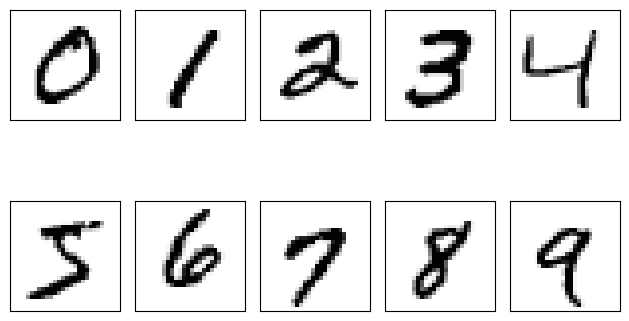

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X[y == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
#plt.savefig('figures/11_4.png', dpi=300)
plt.show()

Visualize 25 different versions of "7":

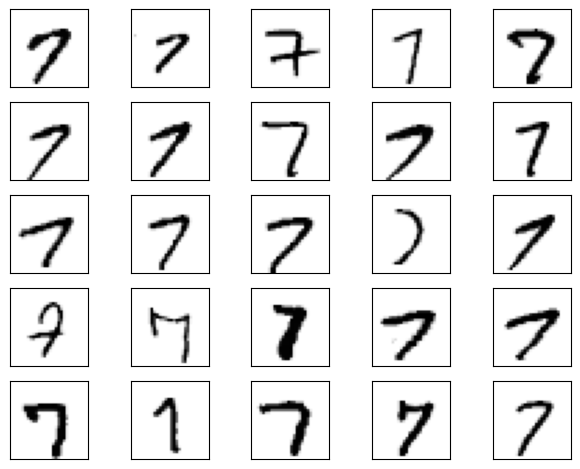

In [ ]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = X[y == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('figures/11_5.png', dpi=300)
plt.show()

Split into training, validation, and test set:

In [ ]:
from sklearn.model_selection import train_test_split


X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=10000, random_state=123, stratify=y)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=5000, random_state=123, stratify=y_temp)


# optional to free up some memory by deleting non-used arrays:
del X_temp, y_temp, X, y

## Implementing a multi-layer perceptron

In [ ]:
import numpy as np

In [ ]:
##########################
### Utils
##########################

### One-hot encoding ###

def int_to_onehot(y, num_labels):

    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1

    return ary


### activation functions ###
def activation_function_hidden_layer(z):
    return sigmoid(z)

def activation_function_derivative_hidden_layer(a):
    return sigmoid_derivative(a)


def activation_function_output_layer(z):
    return softmax(z)



# Sigmoid Activation
def sigmoid(z):                                        
    return 1. / (1. + np.exp(-z))

def sigmoid_derivative(a):
    """
    Derivative of sigmoid with respect to z,
    given the sigmoid activation a = sigmoid(z)
    """
    return a * (1. - a)


def softmax(z):
    return np.exp(z) / np.sum(np.exp(z))



### loss functions ###
def loss_function(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

def loss_function_derivative(y_true, y_pred):
    return mean_squared_error_derivative(y_true, y_pred)


# MSE Loss
def mean_squared_error(y_true, y_pred):
    n_examples = y_true.shape[0]
    return np.sum((y_true - y_pred) ** 2) / n_examples

def mean_squared_error_derivative(y_true, y_pred):  
    n_examples = y_true.shape[0]
    return (2.0 / n_examples) * (y_pred - y_true)

In [ ]:
class NeuralNetMLP:

    def __init__(self, num_features, hidden_layers, num_classes, random_seed=123):
        """Initializes a multi-layer perceptron (MLP) neural network.
        Args:
            num_features (int): Number of input features.
            hidden_layers (list[int]): Sizes of the hidden layers
                (e.g., [128, 64] for two hidden layers).
            num_classes (int): Number of output classes.
            random_seed (int, optional): Random seed for reproducibility.
                Defaults to 123.
        Returns:
            None
        """
        self.num_classes = num_classes
        self.hidden_layers = hidden_layers

        rng = np.random.RandomState(random_seed)

        # ---- Build layer dimensions ----
        #              input layer     hidden layers    output layer
        layer_sizes = [num_features] + hidden_layers + [num_classes]

        # ---- Initialize weights & biases ----
        self.weights = []
        self.biases = []

        for i in range(len(layer_sizes) - 1):
            self.weights.append(
                rng.normal(loc=0.0, scale=0.1,
                           #          output_dim     input_dim
                           size=(layer_sizes[i + 1], layer_sizes[i]))
            )
            #                              output_dim
            self.biases.append(np.zeros(layer_sizes[i + 1]))


    ##### Forward ###### 
    def forward(self, x) -> list[np.ndarray]:
        """Performs a forward pass through the network.
        Args:
            x (np.ndarray): Input data of shape (n_samples, n_features).
        Returns:
            list[np.ndarray]: Activations of all layers (excluding input).
                Each element has shape (n_samples, n_units_in_layer).
                The last element corresponds to the output layer.
        """
        activations = []
        a = x   # input layer "activations" vector

        for W, b in zip(self.weights, self.biases):
            z = np.dot(a, W.T) + b
            if i == len(self.weights) - 1:
                a = activation_function_output_layer(z)
            else:
                a = activation_function_hidden_layer(z)
            activations.append(a)


        return activations # the last element is the output of the network



    ##### Backward ######
    def backward(self, x, activations, y) -> tuple[list[np.ndarray], list[np.ndarray]]:
        """Performs backpropagation to compute gradients of the loss.
        Args:
            x (np.ndarray): Input batch of shape (n_samples, n_features).
            activations (list[np.ndarray]): Activations from the forward pass.
                Each element has shape (n_samples, n_units_in_layer).
                The last element corresponds to the output layer.
            y (np.ndarray): Ground-truth class labels of shape (n_samples,).
        Returns:
            tuple[list[np.ndarray], list[np.ndarray]]:
                - grads_w: Gradients of the loss with respect to weights.
                Each element has the same shape as the corresponding weight matrix.
                - grads_b: Gradients of the loss with respect to biases.
                Each element has the same shape as the corresponding bias vector.
        """
        y_onehot = int_to_onehot(y, self.num_classes)

        grads_w = [None] * len(self.weights)
        grads_b = [None] * len(self.biases)

        # Output layer
        a_out = activations[-1]
        # delta = loss_function_derivative(y_onehot, a_out) * activation_function_derivative_hidden_layer(a_out)
        delta = a_out - y_onehot # when using softmax and MSE

        # Backprop through layers
        for layer in reversed(range(len(self.weights))):
            a_prev = x if layer == 0 else activations[layer - 1]

            grads_w[layer] = np.dot(delta.T, a_prev)
            grads_b[layer] = np.sum(delta, axis=0)

            if layer > 0:
                a_h = activations[layer - 1]
                delta = np.dot(delta, self.weights[layer]) * activation_function_derivative_hidden_layer(a_h)

        return grads_w, grads_b


In [ ]:
model = NeuralNetMLP(num_features=28*28,
                     hidden_layers=[500, 500],
                     num_classes=10)

## Coding the neural network training loop

In [ ]:
import numpy as np

### Defining data Loaders


In [ ]:
# Parameters
num_epochs = 20
minibatch_size = 100

In [ ]:
def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    for start_idx in range(0, indices.shape[0] - minibatch_size 
                           + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]
        
        yield X[batch_idx], y[batch_idx]

        
# iterate over training epochs
for i in range(num_epochs):

    # iterate over minibatches
    minibatch_gen = minibatch_generator(
        X_train, y_train, minibatch_size)
    
    for X_train_mini, y_train_mini in minibatch_gen:

        break
        
    break
    
print(X_train_mini.shape)
print(y_train_mini.shape)

(100, 784)
(100,)


Defining a function to compute the loss and accuracy

In [ ]:
def mse_loss(targets, probas, num_labels=10):
    onehot_targets = int_to_onehot(targets, num_labels=num_labels)
    return np.mean((onehot_targets - probas)**2)


def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets) 


probas = model.forward(X_valid)[-1]
mse = mse_loss(y_valid, probas)

predicted_labels = np.argmax(probas, axis=1)
acc = accuracy(y_valid, predicted_labels)

print(f'Initial validation MSE: {mse:.1f}')
print(f'Initial validation accuracy: {acc*100:.1f}%')

Initial validation MSE: 0.3
Initial validation accuracy: 9.4%


In [ ]:
def compute_mse_and_acc(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)
        
    for i, (features, targets) in enumerate(minibatch_gen):

        probas = nnet.forward(features)[-1]
        predicted_labels = np.argmax(probas, axis=1)
        
        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - probas)**2)
        correct_pred += (predicted_labels == targets).sum()
        
        num_examples += targets.shape[0]
        mse += loss

    mse = mse/(i+1)
    acc = correct_pred/num_examples
    return mse, acc

In [ ]:
mse, acc = compute_mse_and_acc(model, X_valid, y_valid)
print(f'Initial valid MSE: {mse:.1f}')
print(f'Initial valid accuracy: {acc*100:.1f}%')

Initial valid MSE: 0.3
Initial valid accuracy: 9.4%


In [ ]:
def train(model, X_train, y_train, X_valid, y_valid, num_epochs,
          learning_rate=0.1):
    
    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []
    
    for e in range(num_epochs):

        # iterate over minibatches
        minibatch_gen = minibatch_generator(
            X_train, y_train, minibatch_size)

        for X_train_mini, y_train_mini in minibatch_gen:
            
            #### Compute outputs ####
            activations = model.forward(X_train_mini)

            #### Compute gradients ####
            grads_w, grads_b = model.backward(X_train_mini, activations, y_train_mini)
            #### Update weights ####
            for i in range(len(model.weights)):
                model.weights[i] -= learning_rate * grads_w[i]
                model.biases[i] -= learning_rate * grads_b[i]

        #### Epoch Logging ####        
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)
        train_acc, valid_acc = train_acc*100, valid_acc*100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Valid Acc: {valid_acc:.2f}%')

    return epoch_loss, epoch_train_acc, epoch_valid_acc

In [ ]:
np.random.seed(123) # for the training set shuffling

epoch_loss, epoch_train_acc, epoch_valid_acc = train(
    model, X_train, y_train, X_valid, y_valid,
    num_epochs=50, learning_rate=0.1)

Epoch: 001/050 | Train MSE: 0.05 | Train Acc: 76.15% | Valid Acc: 75.98%
Epoch: 002/050 | Train MSE: 0.03 | Train Acc: 85.45% | Valid Acc: 85.04%
Epoch: 003/050 | Train MSE: 0.02 | Train Acc: 87.82% | Valid Acc: 87.60%
Epoch: 004/050 | Train MSE: 0.02 | Train Acc: 89.36% | Valid Acc: 89.28%
Epoch: 005/050 | Train MSE: 0.02 | Train Acc: 90.21% | Valid Acc: 90.04%
Epoch: 006/050 | Train MSE: 0.02 | Train Acc: 90.67% | Valid Acc: 90.54%
Epoch: 007/050 | Train MSE: 0.02 | Train Acc: 91.12% | Valid Acc: 90.82%
Epoch: 008/050 | Train MSE: 0.02 | Train Acc: 91.43% | Valid Acc: 91.26%
Epoch: 009/050 | Train MSE: 0.01 | Train Acc: 91.84% | Valid Acc: 91.50%
Epoch: 010/050 | Train MSE: 0.01 | Train Acc: 92.04% | Valid Acc: 91.84%
Epoch: 011/050 | Train MSE: 0.01 | Train Acc: 92.30% | Valid Acc: 92.08%
Epoch: 012/050 | Train MSE: 0.01 | Train Acc: 92.51% | Valid Acc: 92.24%
Epoch: 013/050 | Train MSE: 0.01 | Train Acc: 92.65% | Valid Acc: 92.30%
Epoch: 014/050 | Train MSE: 0.01 | Train Acc: 92.80

## Evaluating the neural network performance

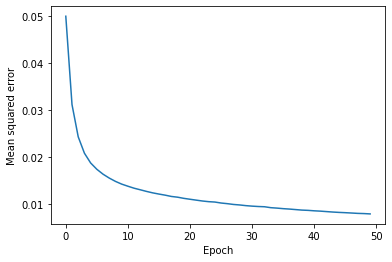

In [ ]:
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
#plt.savefig('figures/11_07.png', dpi=300)
plt.show()

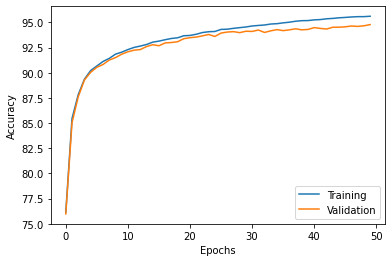

In [ ]:
plt.plot(range(len(epoch_train_acc)), epoch_train_acc,
         label='Training')
plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc,
         label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
#plt.savefig('figures/11_08.png', dpi=300)
plt.show()

In [ ]:
test_mse, test_acc = compute_mse_and_acc(model, X_test, y_test)
print(f'Test accuracy: {test_acc*100:.2f}%')

Test accuracy: 94.54%


Plot failure cases:

In [ ]:
X_test_subset = X_test[:1000, :]
y_test_subset = y_test[:1000]

probas = model.forward(X_test_subset)[-1]
test_pred = np.argmax(probas, axis=1)

misclassified_images = X_test_subset[y_test_subset != test_pred][:25]
misclassified_labels = test_pred[y_test_subset != test_pred][:25]
correct_labels = y_test_subset[y_test_subset != test_pred][:25]

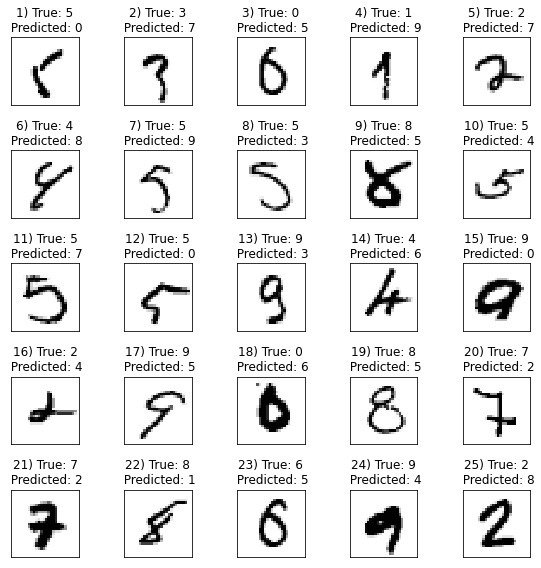

In [ ]:
fig, ax = plt.subplots(nrows=5, ncols=5, 
                       sharex=True, sharey=True, figsize=(8, 8))
ax = ax.flatten()
for i in range(25):
    img = misclassified_images[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title(f'{i+1}) '
                    f'True: {correct_labels[i]}\n'
                    f' Predicted: {misclassified_labels[i]}')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
#plt.savefig('figures/11_09.png', dpi=300)
plt.show()

<br>
<br>